# Objective: Segmentaion of Bank Customers based on various features

In [2]:
## Importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Feature Engineering
## Current Datetime required for calculating customer age
from datetime import datetime
current_date = datetime.now()

## Data Transformation

## Importing Standard Scaler for Scaling Numerical Feature
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

## Model Building
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from kneed import KneeLocator

import warnings
warnings.filterwarnings('ignore')

## To construct a dendrogram
import scipy.cluster.hierarchy as sc

In [3]:
data = pd.read_csv(r'C:\Users\Siddharth Gupta\Downloads\BankCustomerSegmentation\bank_transactions.csv')

In [4]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [5]:
data.shape

(1048567, 9)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [7]:
data.nunique()

TransactionID              1048567
CustomerID                  884265
CustomerDOB                  17254
CustGender                       3
CustLocation                  9355
CustAccountBalance          161328
TransactionDate                 55
TransactionTime              81918
TransactionAmount (INR)      93024
dtype: int64

# Data Preprocessing

In [9]:
## Sum of null values in each column
data.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [10]:
## Dropping all the null values in the dataset
data.dropna(inplace=True)

In [11]:
## Shape of the data after removing null values
data.shape

(1041614, 9)

In [12]:
## Duplicated Records
data.duplicated().sum()

0

In [13]:
## Dropping transaction time as no information provided on formatting and usage
data.drop(columns=['TransactionTime'],inplace=True)

In [14]:
## Checking top 10 transaction frequecy wise customers
transaction_counts = data.groupby('CustomerID').agg({'TransactionID': 'count'}).reset_index()

transaction_counts.columns = ['CustomerID', 'TransactionCount']

# Sorting by transaction count in descending order
transaction_counts = transaction_counts.sort_values(by='TransactionCount', ascending=False)

# Selecting top 10 customers
top_10_customers = transaction_counts.head(10)
print(top_10_customers)

       CustomerID  TransactionCount
4579     C1026833                 6
493983   C5531319                 6
362907   C4327447                 6
328812   C4021562                 6
494656   C5533885                 6
83096    C1736254                 6
611316   C6624352                 6
567113   C6222360                 6
479606   C5418253                 6
243309   C3226689                 6


In [15]:
## Converting the data type of 'TransactionDate' & 'CustomerDOB' columns to datetime with handling errors
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'], errors='coerce')
data['CustomerDOB'] = pd.to_datetime(data['CustomerDOB'], errors='coerce')


# Feature Engineering

In [17]:
# Calculate customer age based on the current date
data['CustomerAge'] = current_date.year - data['CustomerDOB'].dt.year

In [18]:
data['CustomerAge'].unique()

array([ 30, -33,  28, -49,  36, -48,  32,  42,  40,  46, -44, 224,  35,
        33,  39,  31,  38, -43,  45,  47,  27,  41,  34,  44,  43, -42,
        37,  49,  29,  50, -47,  -8, -35,  25, -41, -17, -30, -46,  48,
         3, -45,  20, -19,  26, -27, -36, -32, -29, -23,  24, -40, -24,
       -38, -28, -31, -37, -12, -39, -18, -20, -14, -25, -34, -26, -22,
        22, -21, -13,  17,  23, -15, -16,  11,  21,  19,  14,  13,  -9,
       -10,  -3,   5,  -4,  -6,  15,  -7,  -5, -11,   9,   8,  18,  16,
        12,   1,  -2,   0,   2,  10,   4,  -1,   6], dtype=int64)

In [19]:
# Imputation of Median age in negative Customer Age as DOB mentioned might be wrongly mentioned/recorded
median_dob = data['CustomerDOB'].median()

# Impute CustomerDOB for negative ages
data.loc[data['CustomerAge'] < 0, 'CustomerDOB'] = median_dob

# Recalculate CustomerAge
data['CustomerAge'] = current_date.year - data['CustomerDOB'].dt.year

In [20]:
data['CustomerAge'].unique()

array([ 30,  36,  28,  32,  42,  40,  46, 224,  35,  33,  39,  31,  38,
        45,  47,  27,  41,  34,  44,  43,  37,  49,  29,  50,  25,  48,
         3,  20,  26,  24,  22,  17,  23,  11,  21,  19,  14,  13,   5,
        15,   9,   8,  18,  16,  12,   1,   0,   2,  10,   4,   6],
      dtype=int64)

In [21]:
## There are few records where customer age is mentioned below 18 & in one case, it is mentioned 224 years old
## Removing data where age is less than 18 years of age taking into consideration of information loss
data = data[(data['CustomerAge'] > 17) & (data['CustomerAge'] < 60)]

In [22]:
df = data.reset_index(drop=True)

In [23]:
df['CustomerAge'].unique()

array([30, 36, 28, 32, 42, 40, 46, 35, 33, 39, 31, 38, 45, 47, 27, 41, 34,
       44, 43, 37, 49, 29, 50, 25, 48, 20, 26, 24, 22, 23, 21, 19, 18],
      dtype=int64)

In [24]:
## There are very less records which are lost 
df.shape

(985091, 9)

In [25]:
num_cols = df.select_dtypes(include=np.number)
cat_cols = df.select_dtypes(exclude=np.number)

In [26]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


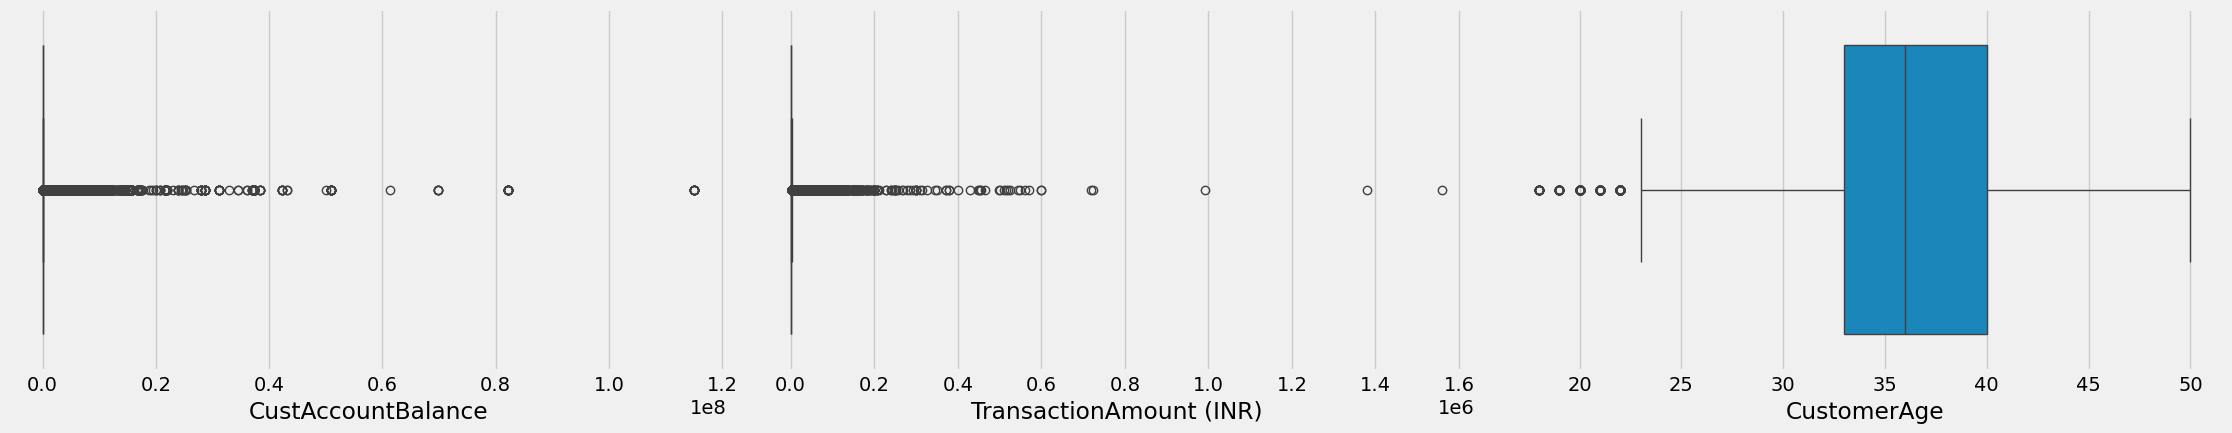

In [27]:
## Checking for Outliers
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,30))
for index,column in enumerate(num_cols):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=num_cols,x=column)
    
plt.tight_layout(pad = 1.0)
plt.show()

In [28]:
## Descriptive Stats of Numerical columns
pd.set_option('display.float_format', '{:.2f}'.format)
num_cols.describe()

,CustAccountBalance,TransactionAmount (INR),CustomerAge
count,985091.00,985091.00,985091.00
mean,106035.73,1452.15,36.79
std,817955.24,6139.97,5.08
min,0.00,0.00,18.00
25%,4580.84,151.00,33.00
50%,16000.52,431.00,36.00
75%,53759.08,1125.00,40.00
max,115035495.10,1560034.99,50.00


In [29]:
## Feature Engineering process for new feature in the dataframe Recency
df['FirstTransaction'] = df['TransactionDate']
df['RecentTransaction'] = df['TransactionDate']

In [30]:
df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),CustomerAge,FirstTransaction,RecentTransaction
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,25.00,30,2016-02-08,2016-02-08
1,T2,C2142763,1988-10-08,M,JHAJJAR,2270.69,2016-02-08,27999.00,36,2016-02-08,2016-02-08
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,459.00,28,2016-02-08,2016-02-08
3,T4,C5342380,1988-10-08,F,MUMBAI,866503.21,2016-02-08,2060.00,36,2016-02-08,2016-02-08
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1762.50,36,2016-02-08,2016-02-08
...,...,...,...,...,...,...,...,...,...,...,...
985086,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,799.00,34,2016-09-18,2016-09-18
985087,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,460.00,32,2016-09-18,2016-09-18
985088,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,770.00,35,2016-09-18,2016-09-18
985089,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1000.00,46,2016-09-18,2016-09-18


In [31]:
## RFM Strategy

rfm_df=df.groupby('CustomerID').agg({
    'CustomerAge' : 'median',
    'CustGender' : 'first',
    'CustLocation' : 'first',
    'TransactionDate':'median',
    'TransactionAmount (INR)' : ['mean'],
    'CustAccountBalance' : 'mean',                  
    'TransactionID' : 'count',
    'FirstTransaction' : 'min',
    'RecentTransaction' : 'max'    
})

rfm_df = rfm_df.reset_index()
rfm_df.head(10)

,CustomerID,CustomerAge,CustGender,CustLocation,TransactionDate,TransactionAmount (INR),CustAccountBalance,TransactionID,FirstTransaction,RecentTransaction
,,median,first,first,median,mean,mean,count,min,max
0,C1010011,36.50,F,NOIDA,2016-09-17 00:00:00,2553.00,76340.63,2,2016-09-08,2016-09-26
1,C1010012,30.00,M,MUMBAI,2016-08-14 00:00:00,1499.00,24204.49,1,2016-08-14,2016-08-14
2,C1010014,36.00,F,MUMBAI,2016-04-08 00:00:00,727.50,100112.95,2,2016-01-08,2016-07-08
3,C1010018,34.00,F,CHAMPARAN,2016-09-15 00:00:00,30.00,496.18,1,2016-09-15,2016-09-15
4,C1010024,36.00,M,KOLKATA,2016-08-18 00:00:00,5000.00,87058.65,1,2016-08-18,2016-08-18
5,C1010028,36.00,F,DELHI,2016-08-29 00:00:00,557.00,296828.37,1,2016-08-29,2016-08-29
6,C1010031,38.00,M,VAPI,2016-03-23 12:00:00,932.00,5200.15,2,2016-03-08,2016-04-08
7,C1010035,38.00,M,MUMBAI,2016-05-03 00:00:00,375.00,192648.76,2,2016-01-08,2016-08-27
8,C1010036,28.00,M,GURGAON,2016-08-26 00:00:00,208.00,355430.17,1,2016-08-26,2016-08-26


In [32]:
rfm_df.shape

(838904, 10)

In [33]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838904 entries, 0 to 838903
Data columns (total 10 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   (CustomerID, )                   838904 non-null  object        
 1   (CustomerAge, median)            838904 non-null  float64       
 2   (CustGender, first)              838904 non-null  object        
 3   (CustLocation, first)            838904 non-null  object        
 4   (TransactionDate, median)        838904 non-null  datetime64[ns]
 5   (TransactionAmount (INR), mean)  838904 non-null  float64       
 6   (CustAccountBalance, mean)       838904 non-null  float64       
 7   (TransactionID, count)           838904 non-null  int64         
 8   (FirstTransaction, min)          838904 non-null  datetime64[ns]
 9   (RecentTransaction, max)         838904 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(3), int64(1), 

In [34]:
# Check for and handle any NaT values in the TransactionDate column
if df['TransactionDate'].isnull().any():
    print("There are missing or invalid dates in the TransactionDate column.")

In [35]:
## Creating new column Recency
rfm_df['Recency'] = (rfm_df[('RecentTransaction', 'max')] - rfm_df[('FirstTransaction', 'min')]).dt.days

In [36]:
rfm_df.head()

,CustomerID,CustomerAge,CustGender,CustLocation,TransactionDate,TransactionAmount (INR),CustAccountBalance,TransactionID,FirstTransaction,RecentTransaction,Recency
,,median,first,first,median,mean,mean,count,min,max,
0,C1010011,36.50,F,NOIDA,2016-09-17,2553.00,76340.63,2,2016-09-08,2016-09-26,18
1,C1010012,30.00,M,MUMBAI,2016-08-14,1499.00,24204.49,1,2016-08-14,2016-08-14,0
2,C1010014,36.00,F,MUMBAI,2016-04-08,727.50,100112.95,2,2016-01-08,2016-07-08,182
3,C1010018,34.00,F,CHAMPARAN,2016-09-15,30.00,496.18,1,2016-09-15,2016-09-15,0
4,C1010024,36.00,M,KOLKATA,2016-08-18,5000.00,87058.65,1,2016-08-18,2016-08-18,0


In [37]:
rfm_df.columns = ['CustomerID', 'Age', 'Gender', 'Location','TransactionDate', 'TransactionAmount(INR)', 'AccountBalance','TransactionFrequency','FirstTransaction', 'RecentTransaction','Recency']

In [38]:
rfm_df

,CustomerID,Age,Gender,Location,TransactionDate,TransactionAmount(INR),AccountBalance,TransactionFrequency,FirstTransaction,RecentTransaction,Recency
0,C1010011,36.50,F,NOIDA,2016-09-17,2553.00,76340.63,2,2016-09-08,2016-09-26,18
1,C1010012,30.00,M,MUMBAI,2016-08-14,1499.00,24204.49,1,2016-08-14,2016-08-14,0
2,C1010014,36.00,F,MUMBAI,2016-04-08,727.50,100112.95,2,2016-01-08,2016-07-08,182
3,C1010018,34.00,F,CHAMPARAN,2016-09-15,30.00,496.18,1,2016-09-15,2016-09-15,0
4,C1010024,36.00,M,KOLKATA,2016-08-18,5000.00,87058.65,1,2016-08-18,2016-08-18,0
...,...,...,...,...,...,...,...,...,...,...,...
838899,C9099836,34.00,M,BHIWANDI,2016-07-08,691.00,133067.23,1,2016-07-08,2016-07-08,0
838900,C9099877,28.00,M,BANGALORE,2016-09-15,222.00,96063.46,1,2016-09-15,2016-09-15,0
838901,C9099919,31.00,M,GUNTUR,2016-08-18,126.00,5559.75,1,2016-08-18,2016-08-18,0
838902,C9099941,29.00,M,CHENNAI,2016-08-28,50.00,35295.92,1,2016-08-28,2016-08-28,0


In [39]:
rfm_df = rfm_df.drop(['FirstTransaction','RecentTransaction'], axis=1)

In [40]:
rfm_df['Recency'].unique()

array([ 18,   0, 182,  31, 232, 123,  13,  68,  17,  36,  32,  29,  62,
        27,  24, 202, 195, 220,   2, 227,  81,   4, 102,  26, 181, 213,
        54,  91,   1, 183,  10,  49,  38, 112,  92, 121,  48,  50, 244,
         3,  30,  35,  45,  66,  19,  28, 193, 158, 204,  46,  93,  25,
       133, 165,  79,  61, 162,  85,  76, 231, 101,   6, 226, 225,  23,
       334, 154,  16, 212, 142, 129,  98, 104,   7,  52, 184,  14, 223,
        47, 229,   5,  80,  11, 152,  39,  60,  40,  43, 245,  75,  97,
       243, 192,  73,  90,   8, 153,  56, 103, 135,  57, 122,  15,   9,
       141, 335, 116, 161,  82,  99, 106, 167,  84, 115,  51, 110,  72,
        67,  12, 219, 201,  44, 228, 197, 235, 190, 124,  37,  87, 159,
       164,  55, 218,  77,  86, 200, 214,  88,  74, 198, 273, 306,  83,
       303,  69, 107, 304, 144,  41, 131, 250,  22, 187,  42, 221, 286,
       186, 151,  21, 236,  63, 126, 170,  71, 249, 175, 137, 230, 275,
       160, 108, 203, 274, 336, 117, 233, 174, 168, 140, 111, 17

In [41]:
## Zero recency means that customer has transacted once so overwriting the 0 to 1
rec_0 = lambda i:1 if i == 0 else i
rfm_df['Recency'] = rfm_df['Recency'].apply(rec_0)

In [42]:
rfm_df = rfm_df.reset_index()

# Exploratory Data Analysis

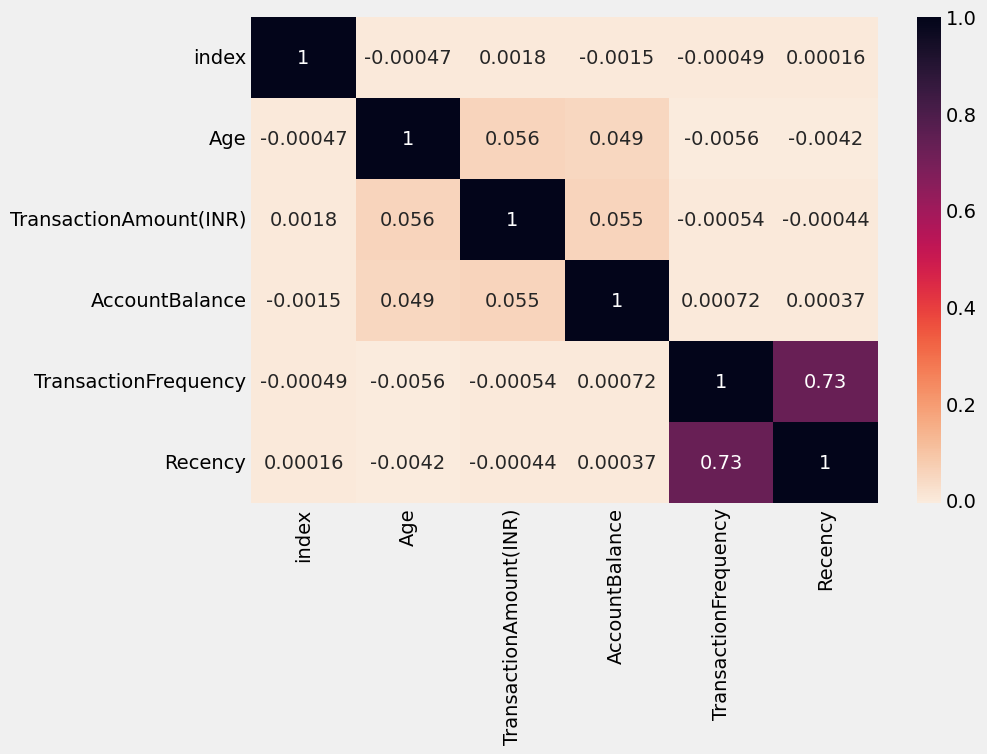

In [44]:
## Correlation among num features
plt.figure(figsize=(9,6))
num_colms = rfm_df.select_dtypes(include=np.number)
corr = num_colms.corr()
sns.heatmap(corr,annot = True,vmin=None,vmax=1,cmap='rocket_r',cbar=True)
plt.show()

In [45]:
## Age & Gender wise records distribution
## Creating a figure with two subplots side by side
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0].hist(x=rfm_df['Age'])
ax[0].set_title("Distribution of Customer Age")
ax[1].pie(rfm_df['Gender'].value_counts(),autopct='%1.f%%',labels=['Male','Female'])
ax[1].set_title("Customer Gender")
plt.tight_layout();

In [46]:
## Sorting top 15 locations with highest no. of customers
loc_count = rfm_df['Location'].value_counts()
sort_loc_count = loc_count.sort_values(ascending=False)
top_15_loc = sort_loc_count.head(15)

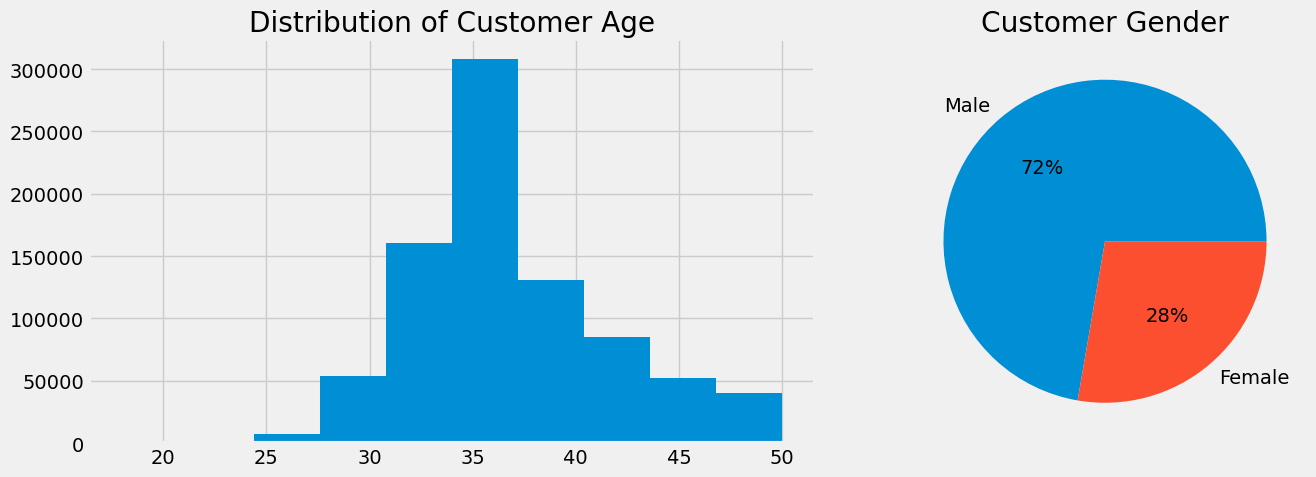

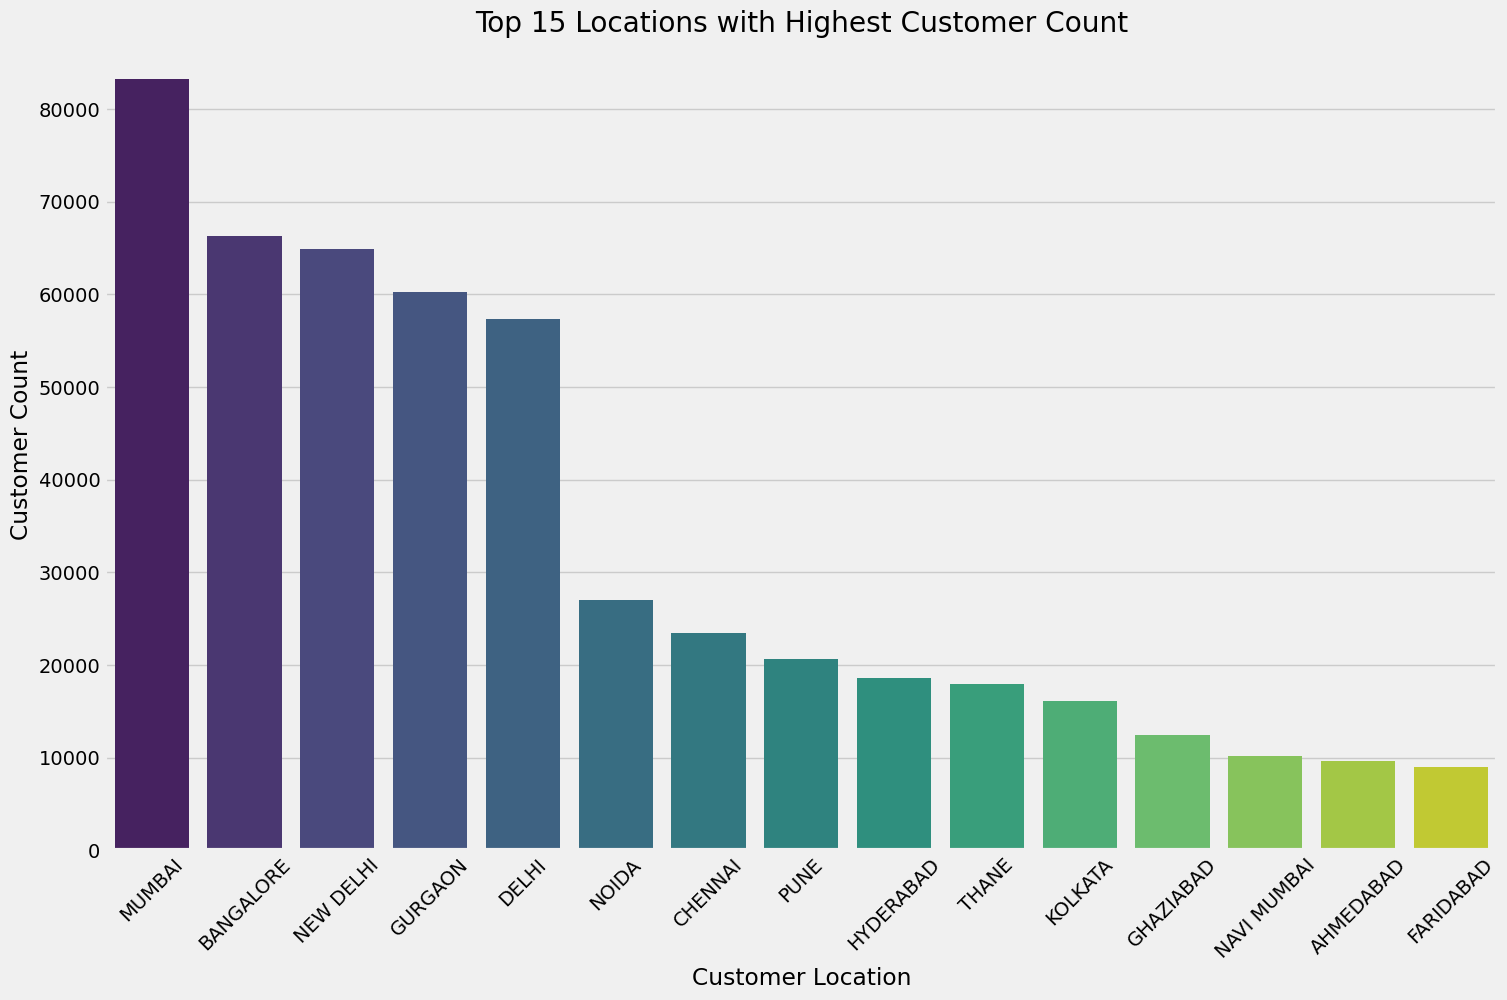

In [47]:
## Plotting top 15 locations with highest no. of customers
plt.figure(figsize=(16, 10))
sns.barplot(x=top_15_loc.index, y=top_15_loc.values,palette='viridis')
plt.title('Top 15 Locations with Highest Customer Count')
plt.xlabel('Customer Location')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)
plt.show()

In [48]:
## No. of people with different frquency of transactions 
ax = sns.countplot(data=rfm_df, x = 'TransactionFrequency', palette ='muted')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=10)

In [49]:
sns.scatterplot(rfm_df, x = 'TransactionAmount(INR)', y = 'AccountBalance', palette ='Spectral', hue = 'TransactionFrequency' )

<Axes: xlabel='TransactionFrequency', ylabel='count'>

In [50]:
## Extracting year and month from TransactionDate, groupby month & calculating median of TransactionAmount
monthly_medians = rfm_df.groupby(pd.Grouper(key='TransactionDate', freq='M')).agg({
    'TransactionAmount(INR)': 'median',
    'AccountBalance': 'median'
}).reset_index()

# Melt the DataFrame for seaborn
monthly_medians_melted = pd.melt(monthly_medians, id_vars='TransactionDate', var_name='Metric', value_name='MedianValue')

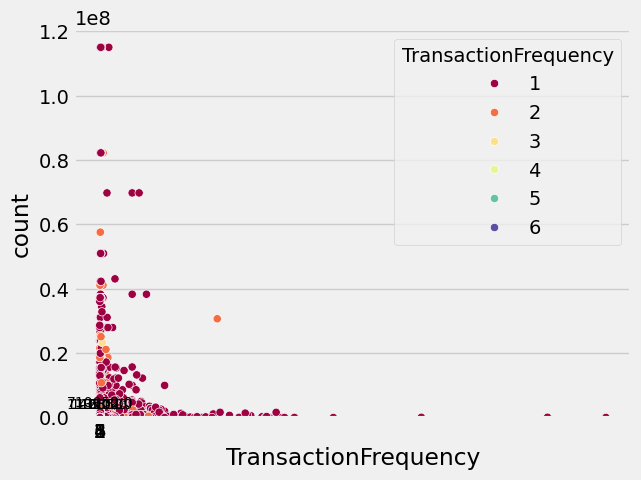

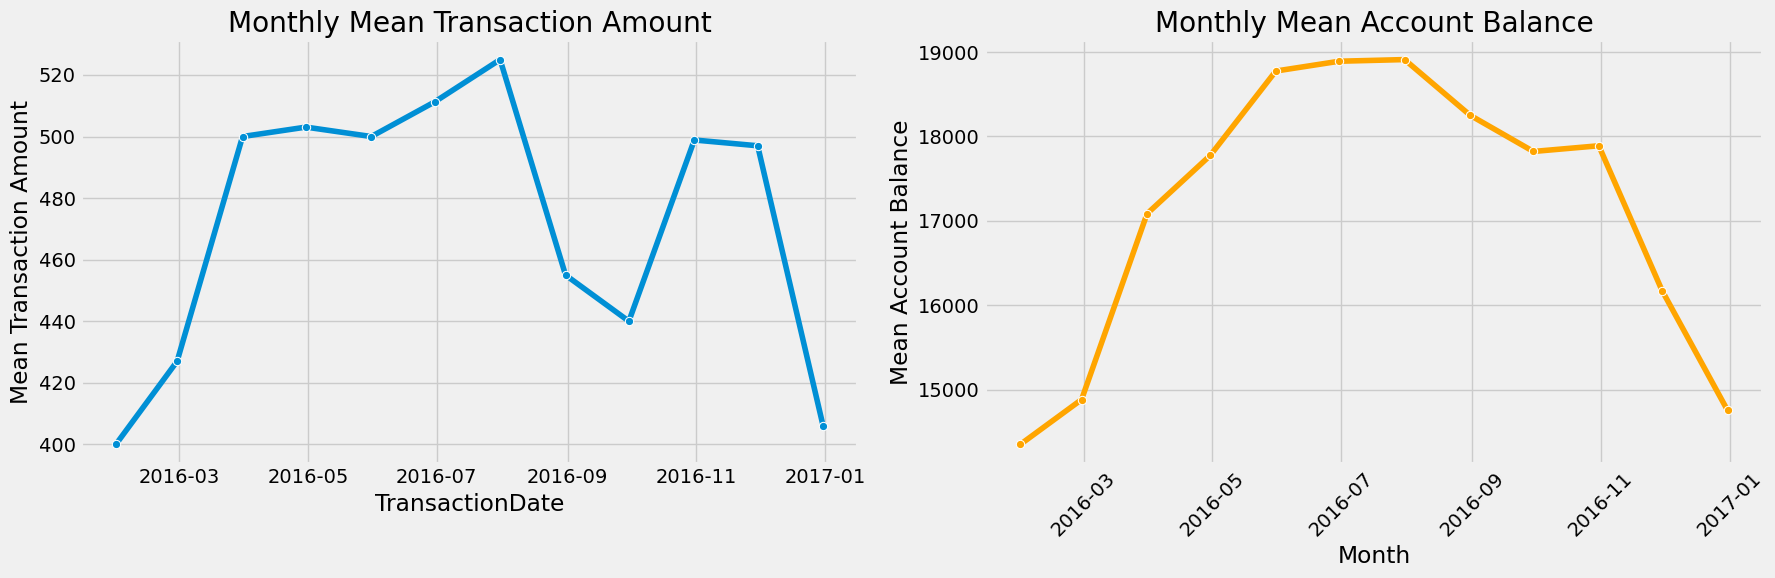

In [51]:
## Creating a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

## Plotting TotalTransactionAmount
sns.lineplot(data=monthly_medians, x='TransactionDate', y='TransactionAmount(INR)', ax=ax1, marker='o')
ax1.set_title('Monthly Mean Transaction Amount')
ax1.set_ylabel('Mean Transaction Amount')
ax1.grid(True)

## Plotting AccountBalance
sns.lineplot(data=monthly_medians, x='TransactionDate', y='AccountBalance', ax=ax2, marker='o', color='orange')
ax2.set_title('Monthly Mean Account Balance')
ax2.set_xlabel('Month')
ax2.set_ylabel('Mean Account Balance')
ax2.grid(True)

## Rotatation of x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [52]:
rfm_df.head()

,index,CustomerID,Age,Gender,Location,TransactionDate,TransactionAmount(INR),AccountBalance,TransactionFrequency,Recency
0,0,C1010011,36.50,F,NOIDA,2016-09-17,2553.00,76340.63,2,18
1,1,C1010012,30.00,M,MUMBAI,2016-08-14,1499.00,24204.49,1,1
2,2,C1010014,36.00,F,MUMBAI,2016-04-08,727.50,100112.95,2,182
3,3,C1010018,34.00,F,CHAMPARAN,2016-09-15,30.00,496.18,1,1
4,4,C1010024,36.00,M,KOLKATA,2016-08-18,5000.00,87058.65,1,1


In [53]:
rfm_df = rfm_df.drop(['CustomerID','Location','TransactionDate'], axis=1)

In [54]:
rfm_df.head()

,index,Age,Gender,TransactionAmount(INR),AccountBalance,TransactionFrequency,Recency
0,0,36.50,F,2553.00,76340.63,2,18
1,1,30.00,M,1499.00,24204.49,1,1
2,2,36.00,F,727.50,100112.95,2,182
3,3,34.00,F,30.00,496.18,1,1
4,4,36.00,M,5000.00,87058.65,1,1


# Data Transformation

In [56]:
## Converting categorical feature
rfm_df['Gender'] = rfm_df['Gender'].map({'M':1 , 'F':0})

In [57]:
## Scaling Numerical Feature with Standard Scaler
df_scaled = StandardScaler().fit_transform(rfm_df)
df_scaled = pd.DataFrame(df_scaled, columns=rfm_df.columns)
df_scaled.head()

,index,Age,Gender,TransactionAmount(INR),AccountBalance,TransactionFrequency,Recency
0,-1.73,-0.06,-1.62,0.18,-0.04,1.90,0.06
1,-1.73,-1.39,0.62,0.01,-0.10,-0.40,-0.31
2,-1.73,-0.16,-1.62,-0.12,-0.01,1.90,3.67
3,-1.73,-0.57,-1.62,-0.24,-0.13,-0.40,-0.31
4,-1.73,-0.16,0.62,0.59,-0.02,-0.40,-0.31


In [58]:
## Sicne the data is very big, we will take a sample of the data for model
df_scaled=df_scaled.sample(n=100000,random_state=42).reset_index(drop=True)
df_scaled.head()

,index,Age,Gender,TransactionAmount(INR),AccountBalance,TransactionFrequency,Recency
0,-0.52,0.86,0.62,0.57,-0.13,-0.40,-0.31
1,-0.21,0.66,-1.62,-0.07,-0.10,-0.40,-0.31
2,-1.44,0.25,-1.62,-0.00,-0.12,1.90,-0.18
3,-1.66,-0.16,-1.62,-0.08,0.96,-0.40,-0.31
4,-0.01,-0.16,0.62,0.07,-0.13,-0.40,-0.31


# Model Building

In [60]:
## KMeans Clustering
## Elbow method to find the K value using KMeans
wcss = []
silhouette_coefficients = []
for k in range(2,11):
    kmeans=KMeans(n_clusters=k, init='random', max_iter=300, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)
    score=silhouette_score(df_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

In [61]:
wcss

[586230.2443001459,
 498824.06387470104,
 443562.48329118616,
 392041.35930137045,
 358895.29191926634,
 314208.6339463814,
 313202.8388796066,
 265247.1884199043,
 253687.63079074814]

In [62]:
silhouette_coefficients

[0.4050998830108533,
 0.3275748350256006,
 0.33218704957748313,
 0.28599898261616735,
 0.29952441976738,
 0.288423035373715,
 0.2917341308679,
 0.3148810983948213,
 0.2998727020809849]

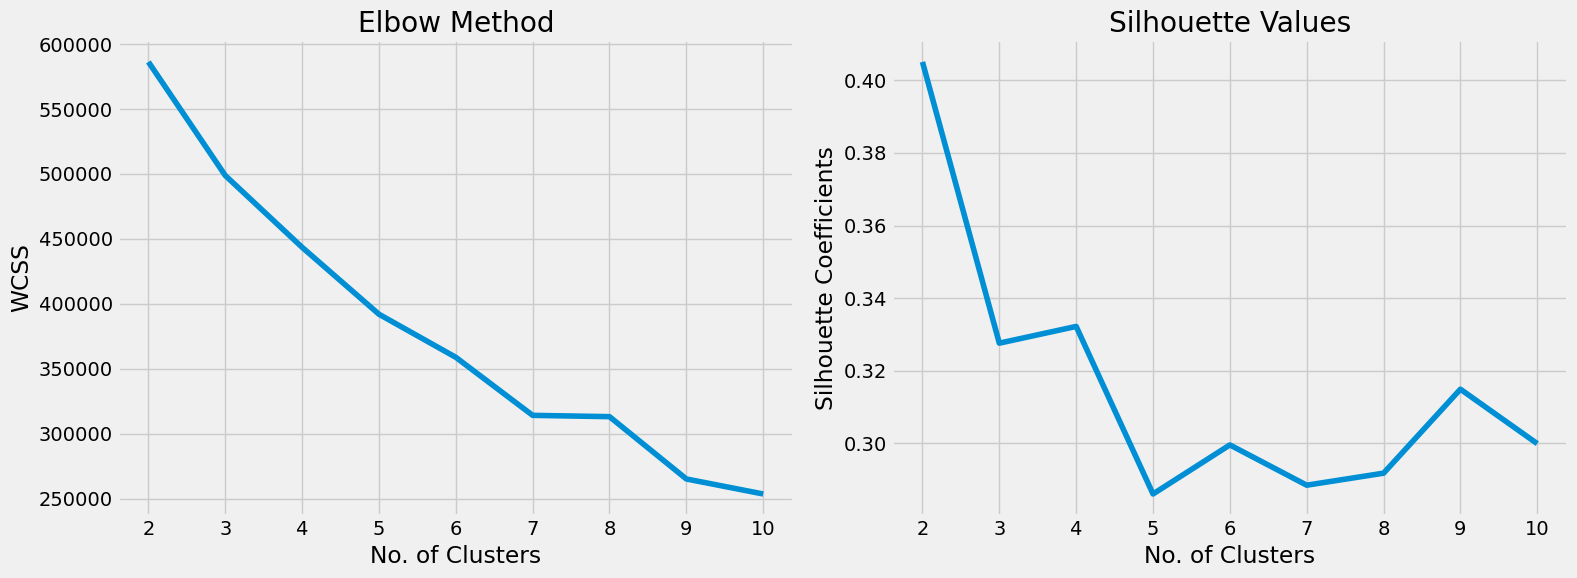

In [63]:
# Creating a figure with 2 subplots side by side
plt.style.use("fivethirtyeight")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
kl = KneeLocator(range(2,11), wcss, curve='convex', direction="increasing")

# Plot WCSS
ax1.plot(range(2, 11), wcss)
ax1.set_xticks(range(2, 11))
ax1.set_xlabel("No. of Clusters")
ax1.set_ylabel("WCSS")
ax1.set_title("Elbow Method")

# Plot silhouette coefficients
ax2.plot(range(2, 11), silhouette_coefficients)
ax2.set_xticks(range(2, 11))
ax2.set_xlabel("No. of Clusters")
ax2.set_ylabel("Silhouette Coefficients")
ax2.set_title("Silhouette Values")

plt.tight_layout()
plt.show()

In [64]:
kl.elbow

10

In [65]:
plt.figure(figsize=(30,10))
z = sc.linkage(df_scaled.iloc[:500,:], 'ward')
sc.dendrogram(z);

In [66]:
# Define parameter grid for DBSCAN
param_grid = {
    'eps': [0.5],
    'min_samples': [20,40]
}

# Hyperparameter tuning for DBSCAN
best_score = -1
best_params = {}

for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(df_scaled)
        
        # Filter out noise points for silhouette score calculation
        if len(set(clusters)) > 1:  # Ensure there is more than one cluster
            score = silhouette_score(df_scaled, clusters)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.3133075298232816
Best Parameters: {'eps': 0.5, 'min_samples': 40}


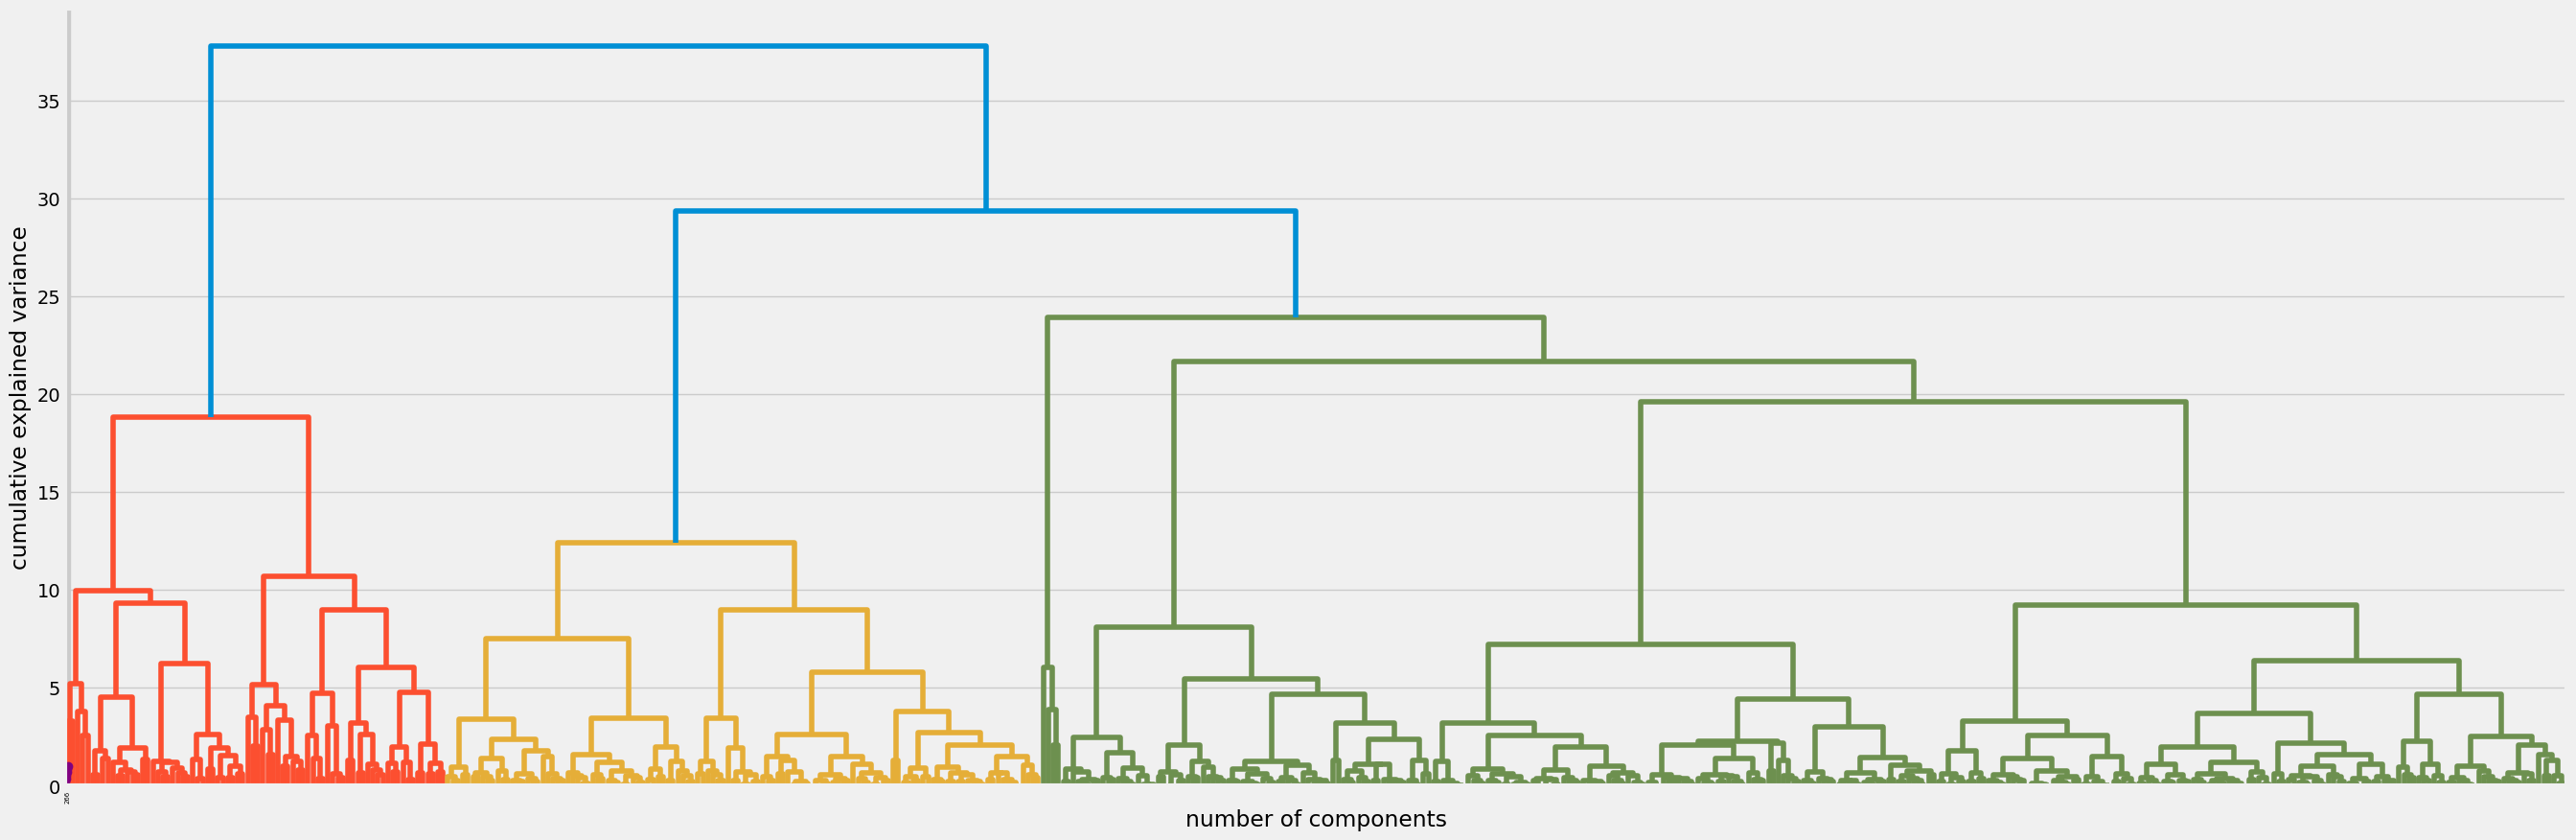

In [67]:
## Applying PCA to improve Silhouette score
pca = PCA().fit(df_scaled.iloc[:,:-1])
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='purple',marker='o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.xticks(np.arange(0, 10, 1))
plt.show();

In [68]:
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1
print(f"Number of components to explain 90% variance: {n_components}")

Number of components to explain 90% variance: 6


In [69]:
pca = PCA(n_components=5)
pca_data = pca.fit_transform(df_scaled.iloc[:,:-1])

wcss = []
silhouette = []


for k in range(2,11):
    km = KMeans(init='k-means++', n_clusters=k, random_state=42)
    km.fit(pca_data)
    wcss.append(km.inertia_)
    P_score=silhouette_score(pca_data, km.labels_)
    silhouette.append(P_score)

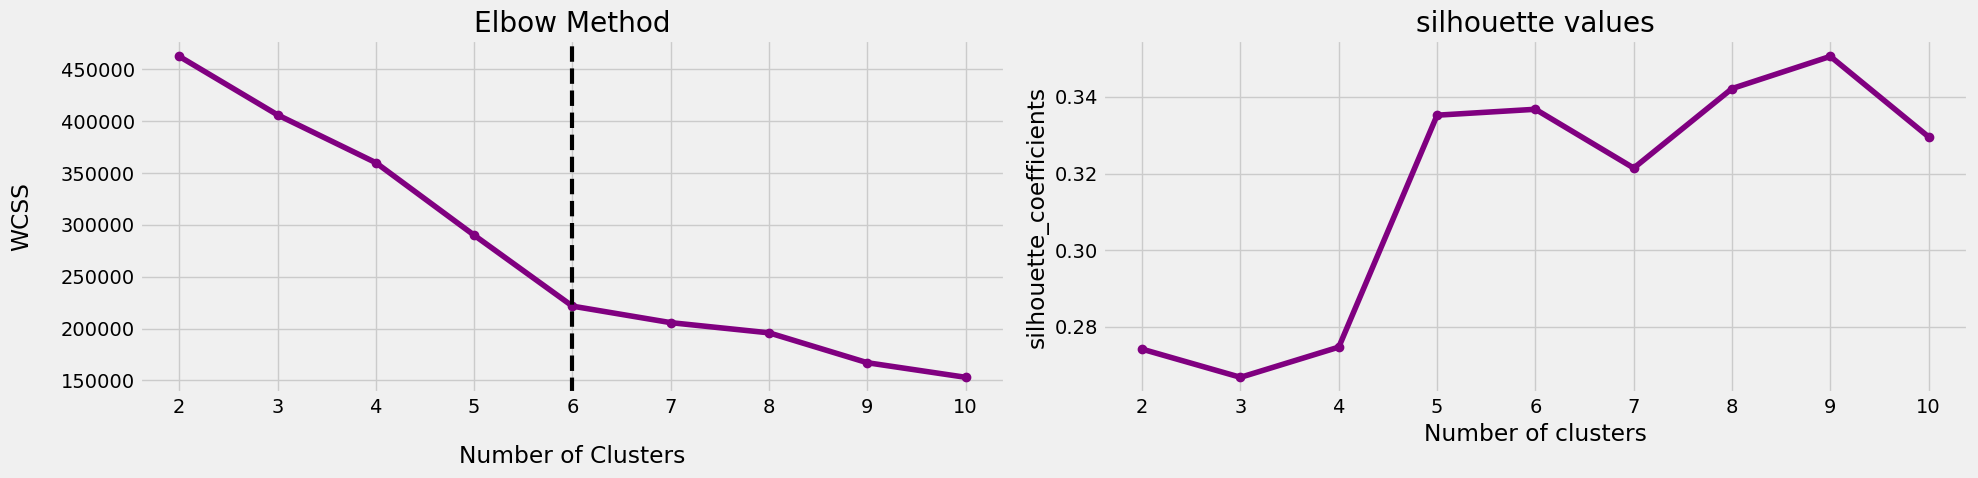

In [70]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(1,2,figsize=(20,5))
pkl = KneeLocator(range(2,11), wcss, curve='convex', direction="decreasing")
# draw Elbow
ax[0].plot(range(2,11), wcss,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("WCSS", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=pkl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)
# draw silhouette
ax[1].plot(range(2,11), silhouette,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();
plt.show()

In [71]:
plt.figure(figsize=(30,10))
z = sc.linkage(pca_data[:350,:], 'ward')
sc.dendrogram(z);